In [51]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [52]:
TITLE_SIZE = 18

#seeding
rng = np.random.default_rng(42)

1 Simulation

In [71]:
# n = number of jobs 
# μ = mean_service_rate
def run_sim_and_plot(n, mean_service_rate):
    
    #contains all E[T] from the simulation
    sim_mean_response_times = [None] * 9
    
    #contains all lamdas derived from the simulation
    sim_mean_arrival_rates = [None] * 9
    
    #contains all theoretical E[T]
    th_mean_response_times = [None] * 9
    
    #contains all theoretical lamdas
    th_mean_arrival_rates = [None] * 9
    
    #runs the simulation 9 times with utilization equal to 0.1, 0.2, ... , 0.9
    for i in range(1,10):
        #returns a dictionary with: number of jobs, μ, λ, 1/λ, 1/μ
        params = build_params(n, mean_service_rate*(i/10), mean_service_rate)
        #prints the params dictionary using Markdown 
        display(Markdown(
            f"### Simulation: n={n}, " +
            f"$\lambda$={format(params['mean_arrival_rate'])}, " +
            f"$\mu$={format(params['mean_service_rate'])}, " +
            f"$1/\lambda$={format(params['mean_interarrival_time'])}, " +
            f"$1/\mu$={format(params['mean_service_time'])}"
        ))
        #returns simulation params such as the E[T] and the calculated lamda
        result = run_sim(params)
        
        sim_mean_response_times[i-1] = result["response_time_mean"]
        sim_mean_arrival_rates[i-1] = result["mean_arrival_rate"]
        
        #Ε[Τ] = Ε[Ν]/λ = 1/(μ-λ)
        th_mean_arrival_rates[i-1] = mean_service_rate*(i/10)
        th_mean_response_times[i-1] = 1/(mean_service_rate-th_mean_arrival_rates[i-1])
        
        dump_stats(result)
    #plots E[T] as a function of lamda for theoretical and simulated M/M/1's    
    plot_response_per_lamda(sim_mean_response_times, sim_mean_arrival_rates, th_mean_response_times, th_mean_arrival_rates)

#builds the param dictionary
def build_params(num_jobs, mean_arrival_rate, mean_service_rate):
    return {
        "n": num_jobs,
        "mean_arrival_rate": mean_arrival_rate,
        "mean_service_rate": mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "mean_service_time": 1.0 / mean_service_rate,
    }
#generates the jobs and their respective arrival, wait, service times using mean_interarrival_time and μ
def run_sim(params):
    #num of jobs
    n = params["n"]
    
    # Parameters
    mean_interarrival_time = params["mean_interarrival_time"]
    mean_service_time = params["mean_service_time"]
    
    # Simulation data and results
    #generating interarrival times using exponential distribution (scale = 1/λ , where λ the rate of the exponential)
    interarrival_times = rng.exponential(scale=mean_interarrival_time, size=n)
    #arrival time of each job is the sum of all the previous interarrival times plus it's own interarrival time
    arrival_times = np.cumsum(interarrival_times)
    #service time μ follows exponential distribution with rate equal to μ
    service_times = rng.exponential(scale=mean_service_time, size=n)
    #now that we know when every job arrives and how much service time it needs we can find when they exit the queue "start_time"
    #and when they get serviced and exit the system "departure time"
    jobs_df = build_jobs_df(params, interarrival_times, arrival_times, service_times)
    #total time (secs) needed to service all jobs
    total_width = get_total_width(jobs_df)
    
    sim_mean_interarrival_time = jobs_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = jobs_df["service_time"].mean()
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = jobs_df["wait_time"].mean()
    sim_response_time_mean = jobs_df["response_time"].mean()
    sim_response_time_var = jobs_df["response_time"].var()
    
    
    
    # utilization
    util = estimate_util(jobs_df)
    
    return {
        "params": params,
        "jobs_df": jobs_df,
        "total_duration": total_width,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "response_time_mean": sim_response_time_mean,
        "utilization": util,
    }

def build_jobs_df(params, interarrival_times, arrival_times, service_times):    
    n = params["n"]
    
    #jobs dataframe
    jobs_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(n),
        "depart_time": np.zeros(n)
    })
    
    #first job gets serviced upon it's arrival time
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    #departs after it get's serviced
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    
    #Every job arrives at the "Queue" upon arrival time and gets serviced when all the jobs that are already in queue get serviced
    #next job get's serviced upon arrival if queue is empty or when the previous job that is currently being serviced finishes
    for i in range(1, n):
        jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
        jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]
    
    #response time for each job is equal to queueing time plus service time or the time from when it arrives to the system
    #until it gets serviced
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]
        
    return jobs_df


#total time system is active is equal to the time that last job finishes minus the arrival time of the 1st job in the system
def get_total_width(jobs_df):
    return jobs_df.iloc[-1]["depart_time"] - jobs_df.iloc[0]["arrive_time"]

#calculates utilization of the system: time the system services jobs / total simulation time
def estimate_util(jobs_df):
    busy = (jobs_df["depart_time"] - jobs_df["start_time"]).sum()
    return busy / get_total_width(jobs_df)

In [72]:
# STATS DUMPS

def format(value):
    return f"{value:,.4f}"

#prints usefull information
def dump_stats(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    response_time = jobs_df["response_time"]
    arrival_rate_mean = result["mean_arrival_rate"]
    service_rate_mean = result["mean_service_rate"]
    service_time_mean = result["mean_service_time"]
    response_time_mean = result["response_time_mean"]
    util = result["utilization"]
    
    print("Simulation statistics")
    print("---------------------")
    print("total_duration          = " + format(result['total_duration']))
    print("arrival_rate_mean       = " + format(arrival_rate_mean))
    print("interarrival_time_mean  = " + format(result['mean_interarrival_time']))
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print("response_time")
    print("  mean                  = " + format(response_time_mean))
    print("wait_time_mean          = " + format(result['mean_wait_time']))
    print("service_rate_mean       = " + format(service_rate_mean))
    print("service_time_mean       = " + format(service_time_mean))
    print("utilization             = " + format(util))

In [75]:
# PLOTTING FUNCTIONS
#plots E[T] as a function of lamda for Theoretical and Simulation Values
def plot_response_per_lamda(sim_mean_response_times, sim_mean_arrival_rates, th_mean_response_times, th_mean_arrival_rates):
    
        
    plt.figure(figsize=(14, 2))
    plt.title("E[T] per Lamda", size=TITLE_SIZE)
    plt.xlabel("lamda")
    plt.ylabel("E[T]")
    plt.plot(th_mean_arrival_rates, th_mean_response_times, label="Theoretical", color="red")
    plt.plot(sim_mean_arrival_rates, sim_mean_response_times, label="Simulation", color="blue")
    plt.legend()
    plt.show()

### Simulation: n=5000, $\lambda$=0.0200, $\mu$=0.2000, $1/\lambda$=50.0000, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 246,677.8767
arrival_rate_mean       = 0.0203
interarrival_time_mean  = 49.3405
response_time
  mean                  = 5.3846
wait_time_mean          = 0.5093
service_rate_mean       = 0.2051
service_time_mean       = 4.8753
utilization             = 0.0988


### Simulation: n=5000, $\lambda$=0.0400, $\mu$=0.2000, $1/\lambda$=25.0000, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 128,949.2423
arrival_rate_mean       = 0.0388
interarrival_time_mean  = 25.7941
response_time
  mean                  = 6.1597
wait_time_mean          = 1.1663
service_rate_mean       = 0.2003
service_time_mean       = 4.9934
utilization             = 0.1936


### Simulation: n=5000, $\lambda$=0.0600, $\mu$=0.2000, $1/\lambda$=16.6667, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 84,642.2374
arrival_rate_mean       = 0.0591
interarrival_time_mean  = 16.9299
response_time
  mean                  = 7.0902
wait_time_mean          = 2.1020
service_rate_mean       = 0.2005
service_time_mean       = 4.9883
utilization             = 0.2947


### Simulation: n=5000, $\lambda$=0.0800, $\mu$=0.2000, $1/\lambda$=12.5000, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 63,375.8043
arrival_rate_mean       = 0.0789
interarrival_time_mean  = 12.6759
response_time
  mean                  = 8.4194
wait_time_mean          = 3.4187
service_rate_mean       = 0.2000
service_time_mean       = 5.0007
utilization             = 0.3945


### Simulation: n=5000, $\lambda$=0.1000, $\mu$=0.2000, $1/\lambda$=10.0000, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 48,450.6574
arrival_rate_mean       = 0.1032
interarrival_time_mean  = 9.6902
response_time
  mean                  = 11.0992
wait_time_mean          = 5.9013
service_rate_mean       = 0.1924
service_time_mean       = 5.1979
utilization             = 0.5364


### Simulation: n=5000, $\lambda$=0.1200, $\mu$=0.2000, $1/\lambda$=8.3333, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 41,766.4619
arrival_rate_mean       = 0.1197
interarrival_time_mean  = 8.3540
response_time
  mean                  = 12.4537
wait_time_mean          = 7.3959
service_rate_mean       = 0.1977
service_time_mean       = 5.0577
utilization             = 0.6055


### Simulation: n=5000, $\lambda$=0.1400, $\mu$=0.2000, $1/\lambda$=7.1429, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 35,153.1167
arrival_rate_mean       = 0.1424
interarrival_time_mean  = 7.0236
response_time
  mean                  = 18.5964
wait_time_mean          = 13.4827
service_rate_mean       = 0.1956
service_time_mean       = 5.1137
utilization             = 0.7273


### Simulation: n=5000, $\lambda$=0.1600, $\mu$=0.2000, $1/\lambda$=6.2500, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 31,214.3144
arrival_rate_mean       = 0.1603
interarrival_time_mean  = 6.2364
response_time
  mean                  = 23.4132
wait_time_mean          = 18.4501
service_rate_mean       = 0.2015
service_time_mean       = 4.9631
utilization             = 0.7950


### Simulation: n=5000, $\lambda$=0.1800, $\mu$=0.2000, $1/\lambda$=5.5556, $1/\mu$=5.0000

Simulation statistics
---------------------
total_duration          = 27,612.6356
arrival_rate_mean       = 0.1812
interarrival_time_mean  = 5.5181
response_time
  mean                  = 52.3893
wait_time_mean          = 47.3454
service_rate_mean       = 0.1983
service_time_mean       = 5.0438
utilization             = 0.9133


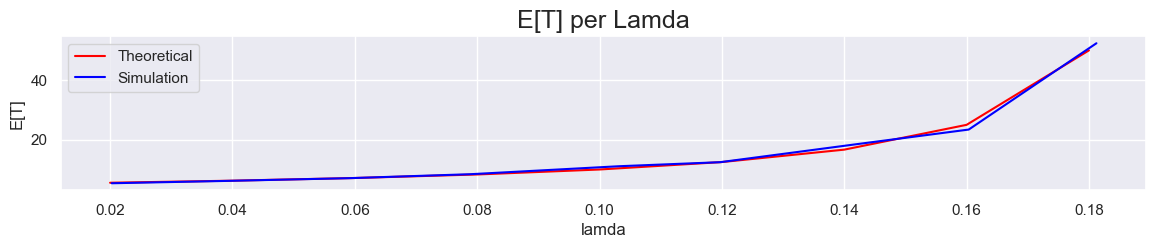

In [77]:
##for mu in [64, 32, 18, 16, 15, 12]:
run_sim_and_plot(5000, 1/5)